In [312]:
# upload datasets
import pandas as pd
import nltk, re, pprint
import sys
from operator import itemgetter
from DB_fn import load_from_DB
import json
import pymongo
import matplotlib.pyplot as plt
#president vote state totals
state_pres = pd.read_csv('president_state.csv', sep=',')
print(state_count.shape)
#hashtag Biden
biden_tweets = pd.read_csv('hashtag_joebiden.csv', sep=',',lineterminator='\n',low_memory= False)
print(biden_tweets.shape)
#hashtag Trump
trump_tweets = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n', low_memory=False)
print(trump_tweets.shape)

(52, 3)
(777078, 21)
(970919, 21)


In [2]:
#check the data types of the coloumns
print(biden_tweets.dtypes)
print(trump_tweets.dtypes)

created_at               object
tweet_id                 object
tweet                    object
likes                    object
retweet_count           float64
source                   object
user_id                  object
user_name                object
user_screen_name         object
user_description         object
user_join_date           object
user_followers_count     object
user_location            object
lat                      object
long                     object
city                     object
country                  object
continent                object
state                    object
state_code               object
collected_at\r           object
dtype: object
created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
source                   object
user_id                 float64
user_name                object
user_screen_name         object
user_description         o

In [3]:
#convert biden likes from object to float
biden_tweets['likes']= pd.to_numeric(biden_tweets['likes'],errors = 'coerce')
print(biden_tweets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777078 entries, 0 to 777077
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            777073 non-null  object 
 1   tweet_id              776995 non-null  object 
 2   tweet                 776995 non-null  object 
 3   likes                 776883 non-null  float64
 4   retweet_count         776895 non-null  float64
 5   source                776182 non-null  object 
 6   user_id               776889 non-null  object 
 7   user_name             776877 non-null  object 
 8   user_screen_name      776895 non-null  object 
 9   user_description      694885 non-null  object 
 10  user_join_date        776784 non-null  object 
 11  user_followers_count  776885 non-null  object 
 12  user_location         543066 non-null  object 
 13  lat                   355284 non-null  object 
 14  long                  355284 non-null  object 
 15  

In [4]:
#check for na's in the dataframe 
print(biden_tweets.isnull().sum().sum())
print(trump_tweets.isnull().sum().sum())
#remove na's from dataframe
biden_tweets=biden_tweets.dropna(axis=0)
trump_tweets=trump_tweets.dropna(axis=0)
#check data
print(biden_tweets.head())
print(trump_tweets.head())

3648467
4568361
         created_at  tweet_id  \
6   10/15/2020 0:00  1.32E+18   
17  10/15/2020 0:01  1.32E+18   
25  10/15/2020 0:01  1.32E+18   
28  10/15/2020 0:02  1.32E+18   
29  10/15/2020 0:02  1.32E+18   

                                                tweet  likes  retweet_count  \
6   In 2020, #NYPost is being #censorship #CENSORE...    0.0            0.0   
17  Comments on this? "Do Democrats Understand how...    0.0            0.0   
25  @RealJamesWoods #BidenCrimeFamily #JoeBiden #H...    0.0            0.0   
28  #Trump #Obama #Clinton #Biden\n\n#ManWomanPers...    0.0            0.0   
29  Come on @ABC PLEASE DO THE RIGHT THING. Move t...    0.0            0.0   

                 source    user_id  \
6    Twitter for iPhone   19940334   
17      Twitter Web App  101659277   
25  Twitter for Android   1.30E+18   
28   Twitter for iPhone  132163121   
29      Twitter Web App  334322367   

                                            user_name user_screen_name  \
6   Cha

In [5]:
#check to see if nas are gone
print(biden_tweets.isnull().sum().sum())
print(trump_tweets.isnull().sum().sum())

0
0


In [6]:
#remove the #'s and @'s
def remove_at(x):
    x = str(x).replace('@', '')
    x = str(x).replace('#', '')
    return x

In [7]:
# Clearning the biden data with the function
biden_tweets['tweet'] = biden_tweets['tweet'].apply(lambda x: remove_at(x))

In [8]:
# clean the trump data 
trump_tweets['tweet'] = trump_tweets['tweet'].apply(lambda x: remove_at(x))

In [9]:
#make a subsetted dataframe for the tweets
bt_mini=(biden_tweets[['user_name', 'user_screen_name','tweet','likes','retweet_count','state','country']])
print(bt_mini.head())
#trump
tt_mini=(trump_tweets[['user_name', 'user_screen_name','tweet','likes','retweet_count','state','country']])
print(tt_mini.head())

                                            user_name user_screen_name  \
6   Change Illinois | Biden will increase taxes by...   changeillinois   
17                                        John Ubaldi    ubaldireports   
25                                           Sam KEYS  SamKEYS65729181   
28                                 Saroop Rooprai FIA    roshannnikhil   
29                                          Elphygirl        Elphygirl   

                                                tweet  likes  retweet_count  \
6   In 2020, NYPost is being censorship CENSORED b...    0.0            0.0   
17  Comments on this? "Do Democrats Understand how...    0.0            0.0   
25  RealJamesWoods BidenCrimeFamily JoeBiden Hunte...    0.0            0.0   
28  Trump Obama Clinton Biden\n\nManWomanPersonCam...    0.0            0.0   
29  Come on ABC PLEASE DO THE RIGHT THING. Move th...    0.0            0.0   

         state                   country  
6     Illinois  United States of Amer

In [10]:
#change united States of America to just United states for easier analysis
bt_mini= bt_mini.replace(to_replace = 'United States of America', value = 'United States')
tt_mini= tt_mini.replace(to_replace = 'United States of America', value = 'United States')

In [11]:
#restrict tweets to just those from the united states and check length
bt_states= bt_mini[(bt_mini.country =='United States')]
print(bt_states.head())
print('number of US tweets about Biden: ', len(bt_states))
tt_states= tt_mini[(tt_mini.country =='United States')]
print(tt_states.head())
print('number of US tweets about Trump: ', len(tt_states))

                                            user_name user_screen_name  \
6   Change Illinois | Biden will increase taxes by...   changeillinois   
17                                        John Ubaldi    ubaldireports   
25                                           Sam KEYS  SamKEYS65729181   
29                                          Elphygirl        Elphygirl   
34                                        Truth Hurts     TheTruthSekr   

                                                tweet  likes  retweet_count  \
6   In 2020, NYPost is being censorship CENSORED b...    0.0            0.0   
17  Comments on this? "Do Democrats Understand how...    0.0            0.0   
25  RealJamesWoods BidenCrimeFamily JoeBiden Hunte...    0.0            0.0   
29  Come on ABC PLEASE DO THE RIGHT THING. Move th...    0.0            0.0   
34  realDonaldTrump addresses JoeBiden and HunterB...    0.0            1.0   

         state        country  
6     Illinois  United States  
17     Florida  

In [12]:
#create dataframes of the number of tweets, likes, and retweets by states
tt_like_rt= tt_states.groupby(['state']).mean()
tt_like_rt.reset_index(inplace=True)
print(tt_like_rt.head())
bt_like_rt= bt_states.groupby(['state']).mean()
bt_like_rt.reset_index(inplace=True)
print(bt_like_rt.head())
#tweet counts about biden by state
bstate_tweet= bt_states.groupby("state")["tweet"].count()
bstate_tweet= pd.DataFrame(bstate_tweet)
bstate_tweet.reset_index(inplace=True)
print(bstate_tweet.head())
#tweet counts about trump by state
tstate_tweet= tt_states.groupby("state")["tweet"].count()
tstate_tweet= pd.DataFrame(tstate_tweet)
tstate_tweet.reset_index(inplace=True)
print(tstate_tweet.head())

        state     likes  retweet_count
0     Alabama  6.334471       1.419795
1      Alaska  2.318182       0.488636
2     Arizona  2.131710       0.538077
3    Arkansas  2.367647       0.367647
4  California  5.688748       1.339421
        state     likes  retweet_count
0     Alabama  4.472727       0.869091
1      Alaska  2.074380       0.272727
2     Arizona  5.510086       0.995389
3    Arkansas  1.333333       0.333333
4  California  7.273137       1.271195
        state  tweet
0     Alabama    275
1      Alaska    121
2     Arizona   1735
3    Arkansas     66
4  California  15959
        state  tweet
0     Alabama    293
1      Alaska     88
2     Arizona   1602
3    Arkansas     68
4  California  18673


In [126]:
trump_lrt_ne=tt_like_rt[tt_like_rt['state'].isin(['Connecticut', 'New York', 'Maine', 'Rhode Island', 'Vermont', 'New Hampshire', 'Pennsylvania', 'Delaware', 'New Jersey']) ]
print(trump_lrt_ne.head())
trump_tweet_ne=tstate_tweet[tstate_tweet['state'].isin(['Connecticut', 'New York', 'Maine', 'Rhode Island', 'Vermont', 'New Hampshire', 'Pennsylvania', 'Delaware', 'New Jersey']) ]
print(trump_tweet_ne.head())

            state      likes  retweet_count
6     Connecticut  20.743455      11.952880
7        Delaware   0.333333       0.000000
19          Maine   0.650000       0.300000
29  New Hampshire   1.590909       0.363636
30     New Jersey   1.169048       0.347619
            state  tweet
6     Connecticut    191
7        Delaware     15
19          Maine     20
29  New Hampshire     22
30     New Jersey    420


In [127]:
biden_lrt_ne= bt_like_rt[bt_like_rt['state'].isin(['Connecticut', 'New York', 'Maine', 'Rhode Island', 'Vermont', 'New Hampshire', 'Pennsylvania', 'Delaware', 'New Jersey']) ]
print(biden_lrt_ne.head())
biden_tweet_ne=bstate_tweet[bstate_tweet['state'].isin(['Connecticut', 'New York', 'Maine', 'Rhode Island', 'Vermont', 'New Hampshire', 'Pennsylvania', 'Delaware', 'New Jersey']) ]
print(biden_tweet_ne.head())

            state      likes  retweet_count
6     Connecticut  10.507042      10.605634
7        Delaware   1.666667       0.285714
19          Maine   0.875000       0.125000
29  New Hampshire   2.535714       0.285714
30     New Jersey   2.088636       0.500000
            state  tweet
6     Connecticut    142
7        Delaware     84
19          Maine      8
29  New Hampshire     28
30     New Jersey    440


In [129]:
trump_lrt_south= tt_like_rt[tt_like_rt['state'].isin(['Alabama', 'Mississippi', 'Georgia', 'Louisiana', 'Tennessee', 'South Carolina', 'North Carolina', 'Florida', 'Arkansas','Kentucky', 'Oklahoma','Texas', 'Virginia', 'West Virginia', 'Maryland', 'Delaware']) ]
print(trump_lrt_south.head())
trump_tweet_south= tstate_tweet[tstate_tweet['state'].isin(['Alabama', 'Mississippi', 'Georgia', 'Louisiana', 'Tennessee', 'South Carolina', 'North Carolina', 'Florida', 'Arkansas','Kentucky', 'Oklahoma','Texas', 'Virginia', 'West Virginia', 'Maryland', 'Delaware']) ]
print(trump_tweet_south.head())

       state     likes  retweet_count
0    Alabama  6.334471       1.419795
3   Arkansas  2.367647       0.367647
7   Delaware  0.333333       0.000000
9    Florida  4.220272       1.355825
10   Georgia  2.561284       0.585708
       state  tweet
0    Alabama    293
3   Arkansas     68
7   Delaware     15
9    Florida   6610
10   Georgia   2211


In [217]:
biden_lrt_south= bt_like_rt[bt_like_rt['state'].isin(['Alabama', 'Mississippi', 'Georgia', 'Louisiana', 'Tennessee', 'South Carolina', 'North Carolina', 'Florida', 'Arkansas','Kentucky', 'Oklahoma','Texas', 'Virginia', 'West Virginia', 'Maryland', 'Delaware']) ]
print(biden_lrt_south)
biden_tweet_south= bstate_tweet[bstate_tweet['state'].isin(['Alabama', 'Mississippi', 'Georgia', 'Louisiana', 'Tennessee', 'South Carolina', 'North Carolina', 'Florida', 'Arkansas','Kentucky', 'Oklahoma','Texas', 'Virginia', 'West Virginia', 'Maryland', 'Delaware']) ]
print(biden_tweet_south)

             state      likes  retweet_count
0          Alabama   4.472727       0.869091
3         Arkansas   1.333333       0.333333
7         Delaware   1.666667       0.285714
9          Florida   5.476261       2.118049
10         Georgia   4.013677       0.945294
17        Kentucky   7.537954       1.158416
18       Louisiana   5.315299       1.050373
20        Maryland   1.774046       0.422901
24     Mississippi   2.148936       0.861702
33  North Carolina   3.432793       0.585319
36        Oklahoma   1.433566       0.311189
41  South Carolina   1.137324       0.207746
43       Tennessee  12.731237       2.626775
44           Texas  11.536338       3.426504
47        Virginia   9.969163       1.649780
49   West Virginia   1.260870       0.173913
             state  tweet
0          Alabama    275
3         Arkansas     66
7         Delaware     84
9          Florida   5413
10         Georgia   2486
17        Kentucky    303
18       Louisiana    536
20        Maryland    655
2

In [220]:
trump_lrt_mw= tt_like_rt[tt_like_rt['state'].isin(['North Dakota', 'Indiana', 'Illinois', 'Ohio', 'Michigan', 'Wisconsin', 'Minnesota', 'Iowa', 'Nebraska','Kansas']) ]
print(trump_lrt_mw)
trump_tweet_mw= tstate_tweet[tstate_tweet['state'].isin(['North Dakota', 'Indiana', 'Illinois', 'Ohio', 'Michigan', 'Wisconsin', 'Minnesota', 'Iowa', 'Nebraska','Kansas']) ]
print(trump_tweet_mw)

           state     likes  retweet_count
13      Illinois  4.292031       1.123906
14       Indiana  0.913043       0.142857
15          Iowa  1.147436       0.294872
16        Kansas  2.333333       1.097701
22      Michigan  3.042419       0.704874
23     Minnesota  1.703655       0.352480
27      Nebraska  1.735537       0.338843
34  North Dakota  0.700000       0.100000
35          Ohio  2.359137       0.479695
49     Wisconsin  2.394231       0.766827
           state  tweet
13      Illinois   4455
14       Indiana    805
15          Iowa    156
16        Kansas    174
22      Michigan   1108
23     Minnesota    766
27      Nebraska    121
34  North Dakota     10
35          Ohio   1576
49     Wisconsin    416


In [219]:
biden_lrt_mw= bt_like_rt[bt_like_rt['state'].isin(['North Dakota', 'Indiana', 'Illinois', 'Ohio', 'Michigan', 'Wisconsin', 'Minnesota', 'Iowa', 'Nebraska','Kansas']) ]
print(biden_lrt_mw)
biden_tweet_mw= bstate_tweet[bstate_tweet['state'].isin(['North Dakota', 'Indiana', 'Illinois', 'Ohio', 'Michigan', 'Wisconsin', 'Minnesota', 'Iowa', 'Nebraska','Kansas']) ]
print(biden_tweet_mw)

           state     likes  retweet_count
13      Illinois  8.132720       1.779374
14       Indiana  2.447833       0.545746
15          Iowa  9.286765       1.441176
16        Kansas  3.415385       1.669231
22      Michigan  3.629592       0.767347
23     Minnesota  3.126238       0.912129
27      Nebraska  3.020134       0.315436
34  North Dakota  0.586207       0.172414
35          Ohio  3.932584       1.168539
50     Wisconsin  4.220870       1.038261
           state  tweet
13      Illinois   3481
14       Indiana    623
15          Iowa    136
16        Kansas    130
22      Michigan    980
23     Minnesota    808
27      Nebraska    149
34  North Dakota     29
35          Ohio   2581
42  South Dakota     10
50     Wisconsin    575


In [147]:
trump_lrt_west= tt_like_rt[tt_like_rt['state'].isin(['California', 'Washington', 'Nevada', 'Idaho', 'Montana', 'Colorado', 'Oregon', 'New Mexico', 'Arizona', 'Wyoming', 'Utah','Alaska','Hawaii']) ]
print(trump_lrt_west.head())
trump_tweet_west= tstate_tweet[tstate_tweet['state'].isin(['California', 'Washington', 'Nevada', 'Idaho', 'Montana', 'Colorado', 'Oregon', 'New Mexico', 'Arizona', 'Wyoming', 'Utah','Alaska','Hawaii']) ]
print(trump_tweet_west.head())

         state     likes  retweet_count
1       Alaska  2.318182       0.488636
2      Arizona  2.131710       0.538077
4   California  5.688748       1.339421
5     Colorado  1.033624       0.192403
11      Hawaii  4.913486       0.824427
         state  tweet
1       Alaska     88
2      Arizona   1602
4   California  18673
5     Colorado   1606
11      Hawaii    393


In [148]:
biden_lrt_west= bt_like_rt[bt_like_rt['state'].isin(['California', 'Washington', 'Nevada', 'Idaho', 'Montana', 'Colorado', 'Oregon', 'New Mexico', 'Arizona', 'Wyoming', 'Utah','Alaska','Hawaii']) ]
print(biden_lrt_west.head())
biden_tweet_west= bstate_tweet[bstate_tweet['state'].isin(['California', 'Washington', 'Nevada', 'Idaho', 'Montana', 'Colorado', 'Oregon', 'New Mexico', 'Arizona', 'Wyoming', 'Utah','Alaska','Hawaii']) ]
print(biden_tweet_west.head())

         state     likes  retweet_count
1       Alaska  2.074380       0.272727
2      Arizona  5.510086       0.995389
4   California  7.273137       1.271195
5     Colorado  4.952663       0.783601
11      Hawaii  2.014925       0.407960
         state  tweet
1       Alaska    121
2      Arizona   1735
4   California  15959
5     Colorado   1183
11      Hawaii    201


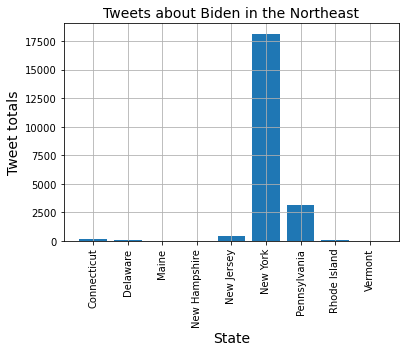

In [149]:
#graph the data in northeast
#biden
plt.bar(biden_tweet_ne['state'], biden_tweet_ne['tweet'])
plt.title('Tweets about Biden in the Northeast', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.grid(True)
plt.xticks(rotation=90) 
plt.show()

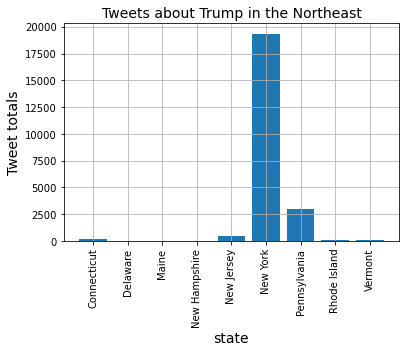

In [150]:
#graph the tweets in the Northeast
#Trump
plt.bar(trump_tweet_ne['state'], trump_tweet_ne['tweet'])
plt.title('Tweets about Trump in the Northeast', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()

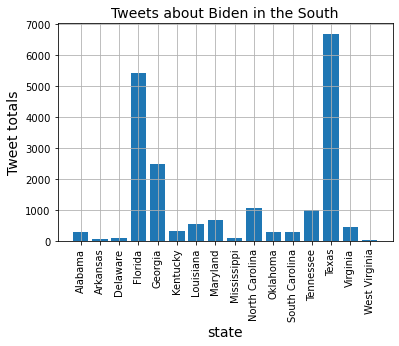

In [165]:
#graph the south region 
#biden
plt.bar(biden_tweet_south['state'], biden_tweet_south['tweet'])
plt.title('Tweets about Biden in the South', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()

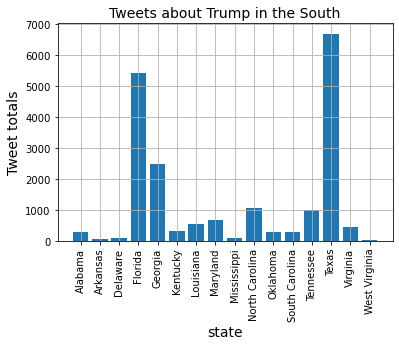

In [161]:
#graph the south region trump
plt.bar(trump_tweet_south['state'], trump_tweet_south['tweet'])
plt.title('Tweets about Trump in the South', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()

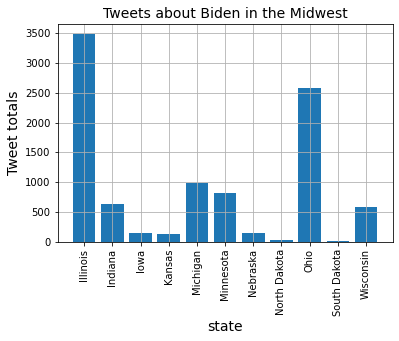

In [163]:
#graph the mw 
#Biden
plt.bar(biden_tweet_mw['state'], biden_tweet_mw['tweet'])
plt.title('Tweets about Biden in the Midwest', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()

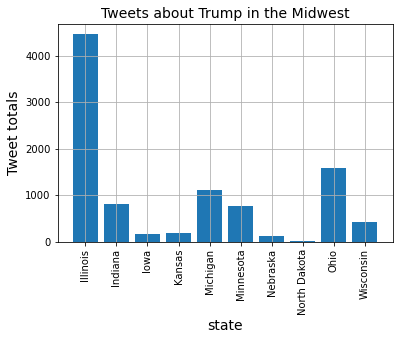

In [166]:
#graph the mw
#trump
plt.bar(trump_tweet_mw['state'], trump_tweet_mw['tweet'])
plt.title('Tweets about Trump in the Midwest', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()

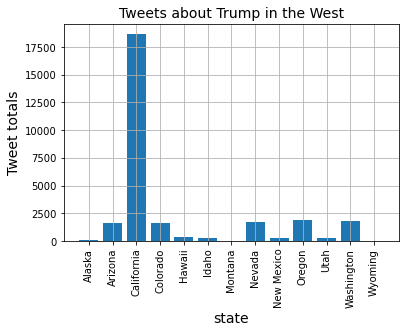

In [167]:
#graph the west
#trump
plt.bar(trump_tweet_west['state'], trump_tweet_west['tweet'])
plt.title('Tweets about Trump in the West', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()

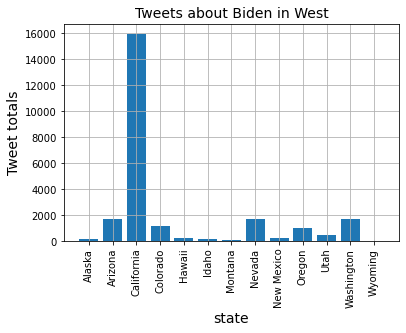

In [168]:
#graph the west
#Biden
plt.bar(biden_tweet_west['state'], biden_tweet_west['tweet'])
plt.title('Tweets about Biden in West', fontsize=14)
plt.xlabel('state', fontsize=14)
plt.ylabel('Tweet totals', fontsize=14)
plt.xticks(rotation=90) 
plt.grid(True)
plt.show()

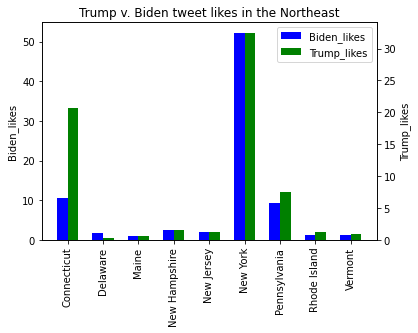

In [199]:
# plot both likes and retweets by region
#north east biden v. Trump likes
x = np.arange(9)
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w/2 , biden_lrt_ne['state'], rotation='vertical')
likes_Biden =ax1.bar(x, biden_lrt_ne['likes'], width=w, color='b', align='center')
plt.ylabel("Biden_likes")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
likes_Trump =ax2.bar(x + w, trump_lrt_ne['likes'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_likes')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden tweet likes in the Northeast')
plt.legend([likes_Biden, likes_Trump],['Biden_likes', 'Trump_likes'])
#To show the plot finally we have used plt.show().
plt.show()

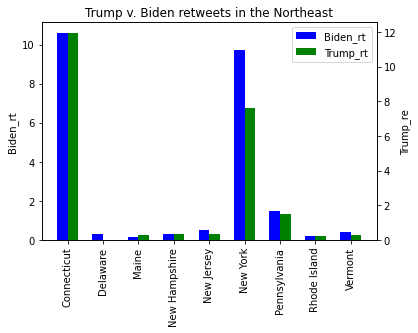

In [227]:
#north east biden v. Trump likes
x = np.arange(9)
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w/2 , biden_lrt_ne['state'], rotation='vertical')
rt_Biden =ax1.bar(x, biden_lrt_ne['retweet_count'], width=w, color='b', align='center')
plt.ylabel("Biden_rt")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
rt_Trump =ax2.bar(x + w, trump_lrt_ne['retweet_count'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_re')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden retweets in the Northeast')
plt.legend([rt_Biden, rt_Trump],['Biden_rt', 'Trump_rt'])
#To show the plot finally we have used plt.show().
plt.show()

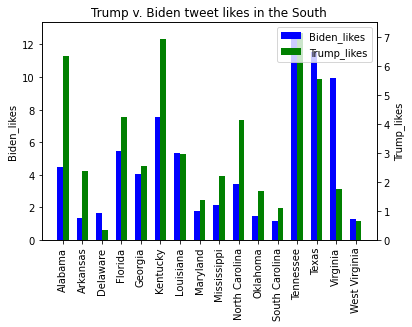

In [201]:
#south biden v. Trump likes
x = np.arange(16)
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w/2 , biden_lrt_south['state'], rotation='vertical')
likes_Biden =ax1.bar(x, biden_lrt_south['likes'], width=w, color='b', align='center')
plt.ylabel("Biden_likes")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
likes_Trump =ax2.bar(x + w, trump_lrt_south['likes'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_likes')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden tweet likes in the South')
plt.legend([likes_Biden, likes_Trump],['Biden_likes', 'Trump_likes'])
#To show the plot finally we have used plt.show().
plt.show()

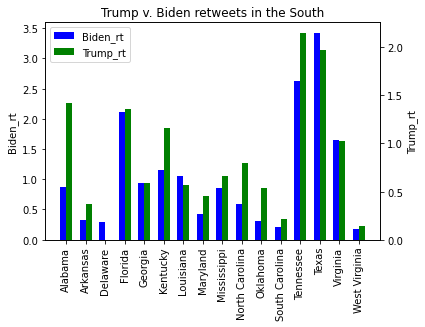

In [226]:
#south biden v. Trump retweets
x = np.arange(16)
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w/2 , biden_lrt_south['state'], rotation='vertical')
rt_Biden =ax1.bar(x, biden_lrt_south['retweet_count'], width=w, color='b', align='center')
plt.ylabel("Biden_rt")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
rt_Trump =ax2.bar(x + w, trump_lrt_south['retweet_count'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_rt')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden retweets in the South')
plt.legend([rt_Biden, rt_Trump],['Biden_rt', 'Trump_rt'])
#To show the plot finally we have used plt.show().
plt.show()

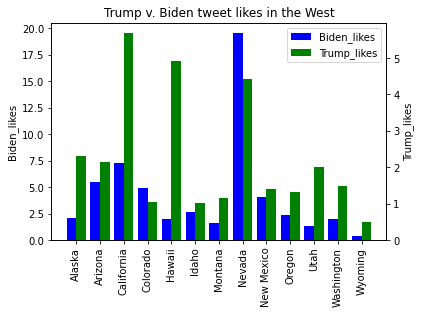

In [208]:
#west biden v. Trump likes
x = np.arange(13)
ax1 = plt.subplot(1,1,1)
w = 0.4
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w/2 , biden_lrt_west['state'], rotation='vertical')
likes_Biden =ax1.bar(x, biden_lrt_west['likes'], width=w, color='b', align='center')
plt.ylabel("Biden_likes")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
likes_Trump =ax2.bar(x + w, trump_lrt_west['likes'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_likes')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden tweet likes in the West')
plt.legend([likes_Biden, likes_Trump],['Biden_likes', 'Trump_likes'])
#To show the plot finally we have used plt.show().
plt.show()

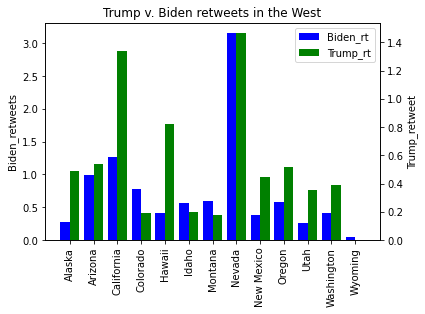

In [224]:
#west biden v. Trump retweets
x = np.arange(13)
ax1 = plt.subplot(1,1,1)
w = 0.4
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w/2 , biden_lrt_west['state'], rotation='vertical')
rt_Biden =ax1.bar(x, biden_lrt_west['retweet_count'], width=w, color='b', align='center')
plt.ylabel("Biden_retweets")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
rt_Trump =ax2.bar(x + w, trump_lrt_west['retweet_count'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_retweet')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden retweets in the West')
plt.legend([rt_Biden, rt_Trump],['Biden_rt', 'Trump_rt'])
#To show the plot finally we have used plt.show().
plt.show()

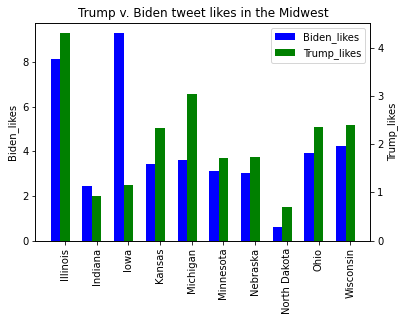

In [223]:
#midwest biden v. Trump likes- no SD due to lack of data with the biden dataset
x = np.arange(10)
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w , biden_lrt_mw['state'], rotation='vertical')
likes_Biden =ax1.bar(x, biden_lrt_mw['likes'], width=w, color='b', align='center')
plt.ylabel("Biden_likes")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
likes_Trump =ax2.bar(x +w, trump_lrt_mw['likes'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_likes')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden tweet likes in the Midwest')
plt.legend([likes_Biden, likes_Trump],['Biden_likes', 'Trump_likes'])
#To show the plot finally we have used plt.show().
plt.show()

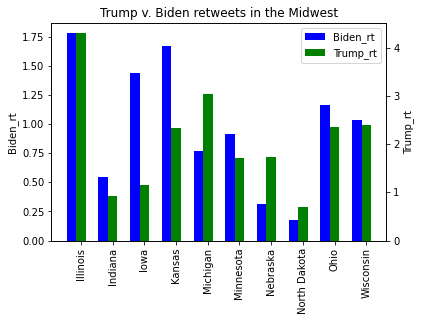

In [225]:
#midwest biden v. Trump retweets- no SD due to lack of data with the biden dataset
x = np.arange(10)
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective country names.
plt.xticks(x + w , biden_lrt_mw['state'], rotation='vertical')
rt_Biden =ax1.bar(x, biden_lrt_mw['retweet_count'], width=w, color='b', align='center')
plt.ylabel("Biden_rt")
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
#We have calculated GDP by dividing gdpPerCapita to population.
rt_Trump =ax2.bar(x +w, trump_lrt_mw['likes'], width=w,color='g',align='center')
#Set the Y axis label as GDP.
plt.ylabel('Trump_rt')
#To set the legend on the plot we have used plt.legend()
plt.title('Trump v. Biden retweets in the Midwest')
plt.legend([rt_Biden, rt_Trump],['Biden_rt', 'Trump_rt'])
#To show the plot finally we have used plt.show().
plt.show()

In [39]:
from textblob import TextBlob

In [67]:
#biden preprocessing for sentiment analysis
##convert to lower case
biden_tweets['clean_text'] = biden_tweets['tweet'].str.lower()
##Remove punctuations
biden_tweets['clean_text'] = biden_tweets['clean_text'].str.replace('[^\w\s]',' ')
##Remove spaces in between words
biden_tweets['clean_text'] = biden_tweets['clean_text'].str.replace(' +', ' ')
##Remove Numbers
biden_tweets['clean_text'] = biden_tweets['clean_text'].str.replace('\d+', '')
##Remove trailing spaces
biden_tweets['clean_text'] = biden_tweets['clean_text'].str.strip()
##Remove URLS
biden_tweets['clean_text'] = biden_tweets['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
##Remove stop words
stop = nltk.corpus.stopwords.words('english')
print(len(stop))
biden_tweets['clean_text'] = biden_tweets['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop ))


179


In [106]:
#trump preprocessing for sentiment analysis
##convert to lower case
trump_tweets['clean_text'] = trump_tweets['tweet'].str.lower()
##Remove punctuations
trump_tweets['clean_text'] = trump_tweets['clean_text'].str.replace('[^\w\s]',' ')
##Remove spaces in between words
trump_tweets['clean_text'] = trump_tweets['clean_text'].str.replace(' +', ' ')
##Remove Numbers
trump_tweets['clean_text'] = trump_tweets['clean_text'].str.replace('\d+', '')
##Remove trailing spaces
trump_tweets['clean_text'] = trump_tweets['clean_text'].str.strip()
##Remove URLS
trump_tweets['clean_text'] = trump_tweets['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
##Remove stop words
stop = nltk.corpus.stopwords.words('english')
print(len(stop))
trump_tweets['clean_text'] = trump_tweets['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop ))
print(type(trump_tweets['clean_text']))

179
<class 'pandas.core.series.Series'>


In [87]:
#textblob sentiment - Biden
biden_tweets['sentiment_score'] = [round(TextBlob(text).sentiment.polarity, 3)for text in biden_tweets['clean_text']]
biden_tweets['sentiment_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral'for score in biden_tweets['sentiment_score']]

In [88]:
#Textblob sentiment -Trump
trump_tweets['sentiment_score'] = [round(TextBlob(text).sentiment.polarity, 3)for text in trump_tweets['clean_text']]
trump_tweets['sentiment_category'] = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral'for score in trump_tweets['sentiment_score']]

C:\Users\jamcc\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Biden Tweet Sentiment Analysis')

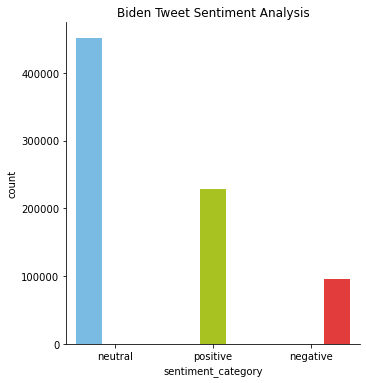

In [101]:
#plot sentiment of biden tweets
bt = sns.factorplot(x="sentiment_category", hue="sentiment_category",
data=biden_tweets, kind="count",
palette={"negative": "#FE2020",
"positive": "#BADD07",
"neutral": "#68BFF5"})
bt.ax.set_title('Biden Tweet Sentiment Analysis')

C:\Users\jamcc\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Trump Tweet Sentiment Analysis')

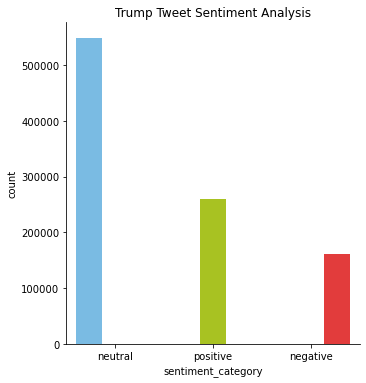

In [102]:
#plot sentiment of Trump tweets
tt = sns.factorplot(x="sentiment_category", hue="sentiment_category",
data=trump_tweets, kind="count",
palette={"negative": "#FE2020",
"positive": "#BADD07",
"neutral": "#68BFF5"})
tt.ax.set_title('Trump Tweet Sentiment Analysis')

In [336]:
pw_northeast= state_pres[state_pres['state'].isin(['Connecticut', 'New York', 'Maine', 'Rhode Island', 'Vermont', 'New Hampshire', 'Pennsylvania', 'New Jersey']) ]
pw_northeast.head()
pw_northeast_biden= pw_northeast.loc[pw_northeast['winner'] == 'BIDEN']
print('Northeastern States Biden Won')
print(pw_northeast_biden)
pw_northeast_trump= pw_northeast.loc[pw_northeast['winner'] == 'TRUMP']
print('Northeastern States Trump Won')
print(pw_northeast_trump)

Northeastern States Biden Won
            state  total_votes winner
12          Maine       819461  BIDEN
22  New Hampshire       804430  BIDEN
23     New Jersey      4564234  BIDEN
25       New York      8613546  BIDEN
31   Pennsylvania      6925255  BIDEN
32   Rhode Island       517757  BIDEN
38        Vermont       367428  BIDEN
49    Connecticut      1824280  BIDEN
Northeastern States Trump Won
Empty DataFrame
Columns: [state, total_votes, winner]
Index: []


In [337]:
pw_south= state_pres[state_pres['state'].isin(['Alabama', 'Mississippi', 'Georgia', 'Louisiana', 'Tennessee', 'South Carolina', 'North Carolina', 'Florida', 'Arkansas','Kentucky', 'Oklahoma','Texas', 'Virginia', 'West Virginia', 'Maryland', 'Delaware']) ]
pw_south.head()
pw_south_biden= pw_south.loc[pw_south['winner'] == 'BIDEN']
print('Southern States Biden Won')
print(pw_south_biden)
pw_south_trump= pw_south.loc[pw_south['winner'] == 'TRUMP']
print('Southern States Trump Won')
print(pw_south_trump)

Southern States Biden Won
       state  total_votes winner
0   Delaware       504010  BIDEN
3    Georgia      4997716  BIDEN
13  Maryland      3037030  BIDEN
39  Virginia      4460524  BIDEN
Southern States Trump Won
             state  total_votes winner
2          Florida     11067456  TRUMP
10        Kentucky      2136768  TRUMP
11       Louisiana      2148062  TRUMP
17     Mississippi      1315182  TRUMP
26  North Carolina      5524801  TRUMP
29        Oklahoma      1560699  TRUMP
33  South Carolina      2513329  TRUMP
35       Tennessee      3054534  TRUMP
36           Texas     11317911  TRUMP
41   West Virginia       794652  TRUMP
44         Alabama      2323304  TRUMP
46        Arkansas      1219069  TRUMP


In [335]:
pw_midwest= state_pres[state_pres['state'].isin(['South Dakota','North Dakota', 'Indiana', 'Illinois', 'Ohio', 'Michigan', 'Wisconsin', 'Minnesota', 'Iowa', 'Nebraska','Kansas']) ]
pw_midwest.head()
pw_midwest_biden= pw_midwest.loc[pw_midwest['winner'] == 'BIDEN']
print('Midwestern States Biden Won')
print(pw_midwest_biden)
pw_midwest_trump= pw_midwest.loc[pw_midwest['winner'] == 'TRUMP']
print('Midwestern States Trump Won')
print(pw_midwest_trump)

Midwestern States Biden Won
        state  total_votes winner
6    Illinois      6038843  BIDEN
15   Michigan      5539302  BIDEN
16  Minnesota      3277171  BIDEN
42  Wisconsin      3297352  BIDEN
Midwestern States Trump Won
           state  total_votes winner
7        Indiana      3033198  TRUMP
8           Iowa      1690871  TRUMP
9         Kansas      1375304  TRUMP
20      Nebraska       956379  TRUMP
27  North Dakota       361819  TRUMP
28          Ohio      5922202  TRUMP
34  South Dakota       422609  TRUMP


In [333]:
pw_west= state_pres[state_pres['state'].isin(['California', 'Washington', 'Nevada', 'Idaho', 'Montana', 'Colorado', 'Oregon', 'New Mexico', 'Arizona', 'Wyoming', 'Utah','Alaska','Hawaii']) ]
len(pw_west['state'])
pw_west_biden= pw_west.loc[pw_west['winner'] == 'BIDEN']
print('Western States Biden Won')
print(pw_west_biden)
pw_west_trump= pw_west.loc[pw_west['winner'] == 'TRUMP']
print('Western States Trump Won')
print(pw_west_trump)

Western States Biden Won
         state  total_votes winner
4       Hawaii       574469  BIDEN
21      Nevada      1405376  BIDEN
24  New Mexico       923965  BIDEN
30      Oregon      2374321  BIDEN
40  Washington      4087631  BIDEN
47  California     17495906  BIDEN
48    Colorado      3256953  BIDEN
51     Arizona      3387326  BIDEN
Western States Biden Won
      state  total_votes winner
5     Idaho       868106  TRUMP
19  Montana       605750  TRUMP
37     Utah      1488289  TRUMP
43  Wyoming       276765  TRUMP
45   Alaska       359530  TRUMP
